In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from math import sqrt

from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [208]:
# Data loading
csv_path = 'datasets_56102_107707_monthly-beer-production-in-austr.csv'
df = pd.read_csv(csv_path, parse_dates=['Month'], index_col='Month')

colname = df.columns[0]
series_vals = df[colname].values.astype(float)
dates = df.index.to_numpy()

T = 12

X_list, Y_list, Y_dates = [], [], []
for t in range(T, len(series_vals)):
    X_list.append(series_vals[t-T:t])
    Y_list.append(series_vals[t])
    Y_dates.append(dates[t])

X_all = np.array(X_list).reshape(-1, T)
Y_all = np.array(Y_list)
Y_dates = np.array(Y_dates)

In [209]:
# Split the data
train_end = np.datetime64('1983-09-01')
train_last_idx = np.where(Y_dates <= train_end)[0]
train_last_idx = train_last_idx[-1]

X_train, Y_train = X_all[:train_last_idx+1], Y_all[:train_last_idx+1]
X_hold, Y_hold = X_all[train_last_idx+1:], Y_all[train_last_idx+1:]
dates_hold = Y_dates[train_last_idx+1:]

print(f"Train samples: {len(X_train)}, Holdout samples: {len(X_hold)}")

Train samples: 321, Holdout samples: 143


In [210]:
# Scale data, scalers fit on training data only
scaler_X = StandardScaler()
scaler_X.fit(X_train.reshape(-1, 1))

X_train_s = scaler_X.transform(X_train.reshape(-1, 1)).reshape(-1, T)
X_hold_s = scaler_X.transform(X_hold.reshape(-1, 1)).reshape(-1, T)

scaler_y = StandardScaler()
scaler_y.fit(Y_train.reshape(-1, 1))
Y_train_s = scaler_y.transform(Y_train.reshape(-1, 1)).reshape(-1)
Y_hold_s = scaler_y.transform(Y_hold.reshape(-1, 1)).reshape(-1)

# (samples, timesteps, features)
X_train_s = X_train_s.reshape(-1, T, 1)
X_hold_s = X_hold_s.reshape(-1, T, 1)

In [211]:
# LSTM model
tf.keras.backend.clear_session()
""" model = Sequential([
    LSTM(128, input_shape=(T, 1), return_sequences=False),
    Dense(1)
]) """
model = Sequential([
    Input(shape=(T, 1)),
    LSTM(128, return_sequences=False),
    Dense(1)
])

lr = 0.01
model.compile(loss='mse', optimizer=Adam(learning_rate=lr))

In [212]:
batch_size = 32
epochs = 100

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train_s, Y_train_s,
    validation_data=(X_hold_s, Y_hold_s),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
    callbacks=[es],
    verbose=2
)


Epoch 1/100
11/11 - 1s - 94ms/step - loss: 0.6082 - val_loss: 0.4326
Epoch 2/100
11/11 - 0s - 9ms/step - loss: 0.5695 - val_loss: 0.5412
Epoch 3/100
11/11 - 0s - 9ms/step - loss: 0.3267 - val_loss: 0.3491
Epoch 4/100
11/11 - 0s - 10ms/step - loss: 0.6917 - val_loss: 0.3598
Epoch 5/100
11/11 - 0s - 9ms/step - loss: 0.5651 - val_loss: 0.5546
Epoch 6/100
11/11 - 0s - 9ms/step - loss: 0.3492 - val_loss: 0.3436
Epoch 7/100
11/11 - 0s - 11ms/step - loss: 0.3427 - val_loss: 0.3845
Epoch 8/100
11/11 - 0s - 8ms/step - loss: 0.4915 - val_loss: 0.4384
Epoch 9/100
11/11 - 0s - 7ms/step - loss: 0.2834 - val_loss: 0.3234
Epoch 10/100
11/11 - 0s - 7ms/step - loss: 0.3643 - val_loss: 0.3541
Epoch 11/100
11/11 - 0s - 8ms/step - loss: 0.3731 - val_loss: 0.2836
Epoch 12/100
11/11 - 0s - 8ms/step - loss: 0.2821 - val_loss: 0.2764
Epoch 13/100
11/11 - 0s - 8ms/step - loss: 0.2103 - val_loss: 0.2627
Epoch 14/100
11/11 - 0s - 8ms/step - loss: 0.2552 - val_loss: 0.3008
Epoch 15/100
11/11 - 0s - 8ms/step - los

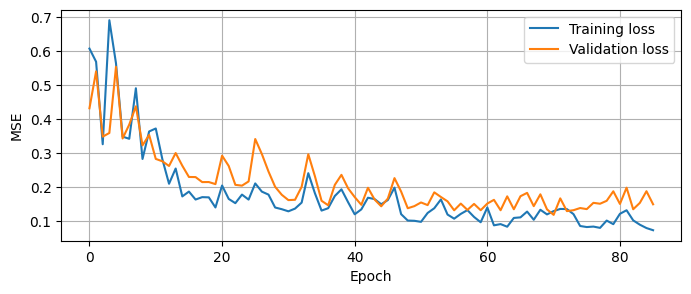

In [213]:
# Plot training history
plt.figure(figsize=(8,3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [214]:
# iterative forecasting
h = len(Y_hold)
preds_scaled = []
last_window = X_train_s[-1].reshape(T, 1).copy()

for _ in range(h):
    p_s = model.predict(last_window.reshape(1, T, 1), verbose=0)[0, 0]
    preds_scaled.append(p_s)
    last_window = np.roll(last_window, -1, axis=0)
    last_window[-1, 0] = p_s

preds_scaled = np.array(preds_scaled)
preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).reshape(-1)

# Compute metrics on holdout
mae = np.mean(np.abs(preds - Y_hold))
rmse = sqrt(np.mean((preds-Y_hold)**2))
print(f'Holdout MAE: {mae:.3f}, RMSE: {rmse:.3f}')

Holdout MAE: 21.489, RMSE: 26.432


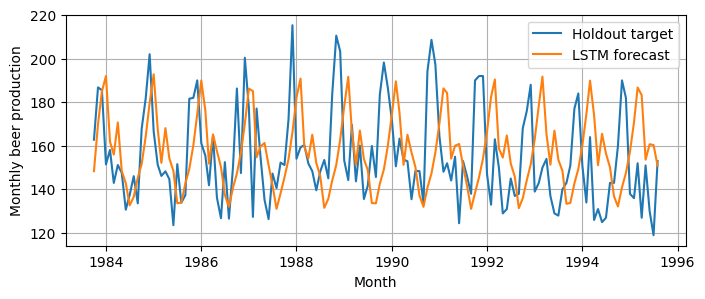

In [216]:
plt.figure(figsize=(8,3))
plt.plot(dates_hold, Y_hold, label='Holdout target')
plt.plot(dates_hold, preds, label='LSTM forecast')
plt.xlabel('Month')
plt.ylabel(colname)
plt.legend()
plt.grid(True)
plt.show()